In [1]:
%pip install pykeops

Note: you may need to restart the kernel to use updated packages.


In [28]:
from pykeops_utils import *
from torch import tensor

import sys
sys.path.insert(1,'../../data/')
from datasets import Deterministic_lotka_volterra

import scipy.io as sio

import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib import cm


def hist_matrix(x_samps, symbols, limits, xtrue):
  dim = x_samps.shape[1]
  plt.figure(figsize=(6,6))
  for i in range(dim):
    for j in range(i+1):
      ax = plt.subplot(dim,dim,(i*dim)+j+1)
      if i ==j:
        plt.hist(x_samps[:,i],bins=40,density=True)
        plt.axvline(xtrue[i],color='r',linewidth=3)
        plt.xlim(limits[i])
      else:
        plt.plot(x_samps[:,j],x_samps[:,i],'.k', markersize=.04, alpha=0.1)
        plt.plot(xtrue[j],xtrue[i],'.r',markersize=8,label='Truth')
        xlim = limits[j]
        ylim = limits[i]
        xx,yy = np.mgrid[xlim[0]:xlim[1]:100j, ylim[0]:ylim[1]:100j]
        positions = np.vstack([xx.ravel(),yy.ravel()])
        kernel = stats.gaussian_kde(x_samps[:,[j,i]].T)
        f = np.reshape(kernel(positions),xx.shape)
        ax.contourf(xx,yy,f,cmap='Blues')
        plt.ylim(limits[i])
      plt.xlim(limits[j])
      if symbols is not None:
        if j ==0:
          plt.ylabel(symbols[i],size=20)
        if i ==len(xtrue)-1:
           plt.xlabel(symbols[j],size=20)
  plt.show()



In [29]:
dtype_ex = torch.float
device_ex = 'cuda'

##########################################################
##########################################################
total_sample_size = 10000
data_available = True
target = Deterministic_lotka_volterra(T=20)
dim_x  = target.d
dim_y  = 18

# define samples
if data_available == False:
    model_data = target.sample_joint(N=total_sample_size)
    torch.save(model_data, './samples.pt')
else:
    # load data
    model_data = torch.load('./samples.pt')

# check moments of data
print(torch.mean(model_data))
print(torch.std(model_data))

# discard outliers
non_outlier_target_idx = torch.where(torch.sum(torch.abs(model_data),axis=1) < 1e4)[0]
model_data = model_data[non_outlier_target_idx,:]

# check moments of data
print(torch.mean(model_data))
print(torch.std(model_data))

# print sizes
print(model_data.shape)

# normalize data
data_mean = torch.mean(model_data,axis=0)
data_std  = torch.std(model_data,axis=0)
model_data = (model_data - data_mean[None,:])/data_std[None,:]

# split into x and y
model_x, model_y = model_data[:,:dim_x], model_data[:,dim_x:]
target_data = torch.hstack((model_y, model_x))
target_data = target_data.to(dtype=dtype_ex,device=device_ex)
source_data = torch.hstack((model_y, torch.randn(model_y.shape[0], dim_x)))
source_data = source_data.to(dtype=dtype_ex,device=device_ex)

target_data = target_data[:total_sample_size]
source_data = source_data[:total_sample_size]

print(target_data.shape)
print(source_data.shape)

tensor(1.1269e+15)
tensor(1.6715e+18)
tensor(22.1628)
tensor(52.0394)
torch.Size([99946, 22])
torch.Size([10000, 22])
torch.Size([10000, 22])


/tmp/ipykernel_368740/2967912744.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_data = torch.load('./samples.pt')


In [30]:
def scale_data(x,beta_vect):
    return x * torch.sqrt(beta_vect)[None,:]

def unscale_map(z,beta_vect):
    return z * torch.sqrt(1./beta_vect)[None,:]

beta = 0.05
beta_vector = torch.ones((dim_x+dim_y),dtype=dtype_ex,device=device_ex)
beta_vector[dim_x:] *= beta
N = len(source_data)

source_data_scaled = scale_data(source_data, beta_vector)
target_data_scaled = scale_data(target_data, beta_vector)
one_over_n = 1./N*torch.ones(source_data.shape[0],dtype=dtype_ex,device=device_ex)

tol_sinkhorn = 5*10**(-4) ### converges in 350 iterations ---- possibly change!
tol_sinkhorn2 = 10**(-4) ### converges in 1000 iterations

eps= torch.tensor([0.05],device=device_ex)
print(target_data_scaled)
print(one_over_n)
print(eps)
print(source_data_scaled)
_,geps = T(eps, one_over_n, source_data_scaled, one_over_n, target_data_scaled, Nits_max=torch.tensor([2000],device=device_ex), keops_available = True)


tensor([[-0.7060,  0.2870, -0.2947,  ..., -0.0083, -0.1896,  0.3349],
        [-0.6672,  1.8082, -0.2550,  ..., -0.2466,  0.2249,  0.1204],
        [-0.7500,  0.1891, -0.2985,  ..., -0.0331, -0.2554,  0.3831],
        ...,
        [-0.5358, -0.5816, -0.2522,  ...,  0.0355, -0.1960, -0.0581],
        [ 1.0256, -0.7483,  1.0083,  ..., -0.0897, -0.1282, -0.2378],
        [-0.7662, -0.3965, -0.2947,  ...,  0.8505, -0.0382, -0.1265]],
       device='cuda:0')
tensor([1.0000e-04, 1.0000e-04, 1.0000e-04,  ..., 1.0000e-04, 1.0000e-04,
        1.0000e-04], device='cuda:0')
tensor([0.0500], device='cuda:0')
tensor([[-0.7060,  0.2870, -0.2947,  ...,  0.2366,  0.0282,  0.1028],
        [-0.6672,  1.8082, -0.2550,  ...,  0.1449,  0.1164,  0.0471],
        [-0.7500,  0.1891, -0.2985,  ...,  0.4841,  0.0701, -0.2107],
        ...,
        [-0.5358, -0.5816, -0.2522,  ..., -0.3291,  0.3895,  0.2734],
        [ 1.0256, -0.7483,  1.0083,  ...,  0.1914,  0.0109, -0.0494],
        [-0.7662, -0.3965, -0.294

TypeError: All variables should either be numpy arrays or torch tensors.

In [ ]:
class ent_map():
    def __init__(self,data,pot,eps):
        self.data = data
        self.pot = pot
        self.eps = eps

    def __call__(self,x):
        M = squared_distances(x,self.data)
        K = -M/self.eps + self.pot/self.eps
        gammaz = -torch.max(K,dim=1)[0]
        K +=  gammaz.view(-1,1) ### does this operation in-place
        torch.exp(K,out=K) ### does this operation in-place
        top_ = torch.matmul(K,self.data)
        bot_ = K.sum(axis=1,keepdim=False)
        entmap = top_.T/bot_
        return entmap

In [ ]:
nsamples = 25000
# load data
data = sio.loadmat('problem_data.mat')
yobs = (data['yobs'] - data_mean[dim_x:].numpy())/data_std[dim_x:].numpy()
xtrue = data['xtrue'][0,:]

# generate samples
x1 = torch.tensor(np.tile(yobs.T, nsamples).T,dtype=dtype_ex,device=device_ex)
rho2_given_1 = torch.randn((nsamples, dim_x),dtype=dtype_ex,device=device_ex)
joint_samples = torch.hstack((x1,rho2_given_1))

In [ ]:
entropic_map_gpu = ent_map(target_data_scaled,geps,eps)
entropic_map_cpu = ent_map(target_data_scaled.to('cpu'),geps.to('cpu'),eps)

In [ ]:
#one_step_gpu = unscale_map( entropic_map_gpu( scale_data(joint_samples,beta_vector)).T,beta_vector)
one_step_cpu = unscale_map( entropic_map_cpu( scale_data(joint_samples,beta_vector).to('cpu') ).T,beta_vector.to('cpu'))

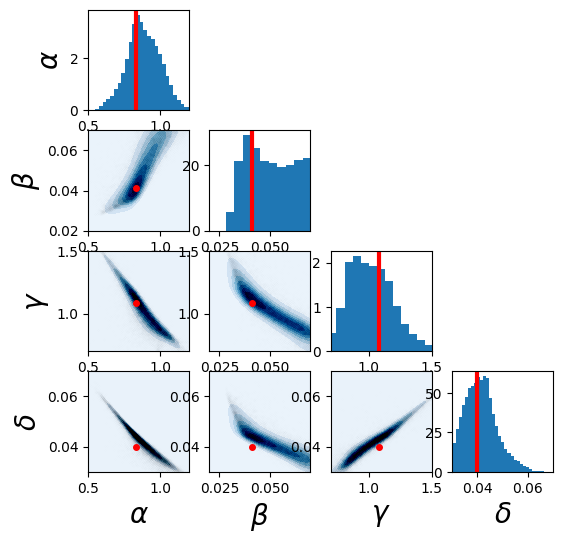

In [ ]:
symbols = [r'$\alpha$',r'$\beta$',r'$\gamma$',r'$\delta$']
limits = [[0.5,1.2],[0.02,0.07],[0.7,1.5],[0.03,0.07]]

# plot samples
cpu_on = True
if cpu_on == True:
    one_step_samples = one_step_cpu[:,dim_y:]
    one_step_samples_recentered = one_step_samples*np.array((data_std[:dim_x])) + np.array(data_mean[:dim_x])
    #x_samples*np.array(data_std[:dim_x]) + np.array(data_mean[:dim_x])
    hist_matrix(one_step_samples_recentered, symbols, limits, xtrue)
else:
    one_step_samples = one_step_gpu[:,dim_y:]
    one_step_samples_recentered = one_step_samples.cpu()*torch.tensor((data_std[:dim_x])) + torch.tensor(data_mean[:dim_x])
    #x_samples*np.array(data_std[:dim_x]) + np.array(data_mean[:dim_x])
    hist_matrix(one_step_samples_recentered.numpy(), symbols, limits, xtrue)


In [ ]:
torch.save(geps, 'geps_10k_eps005_beta005_tol_1eminus4.pt')
torch.save(target_data_scaled, 'targetdatascaled_10k_eps005_beta005_tol_1eminus4.pt')

In [ ]:
with open('samples_10k_eps005_beta005_tol_1eminus4.npy', 'wb') as f:
    np.save(f,one_step_samples_recentered)